In [1]:
import geopandas as gpd
import pandas as pd
import osgeo as osg
import numpy as np
import matplotlib.pyplot as plt
from osgeo import ogr
import os
import pyproj
import datetime

In [8]:
# Read the shapefile
glacier_name = 'Sermeq_Kujalleq_N2'
glacier_id = 'SMK'
region = 'CW'
root_path = '/Users/amankc/Terminus_Ablation/'
path_to_shapefile = root_path +  glacier_name + '/Terminus_Positions/' + 'Filtered_Termini_' + glacier_name + '.shp'
gdf_org = gpd.read_file(path_to_shapefile)
# to sort the file in ascending order
gdf_sorted = gdf_org.iloc[gdf_org['Date'].sort_values().index.values]
# It is not in EPSG 3413
#gdf = gdf_sorted.to_crs(epsg = 3413)
gdf=gdf_sorted;
print(gdf_org.crs)
print('\n',gdf.crs)

None

 None


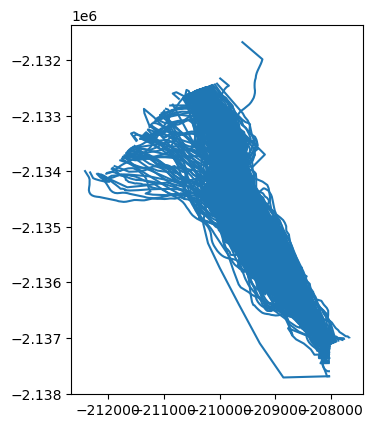

In [25]:
gdf.plot()
gdf_date = gdf.Date;
updated_dates = []
for date_str in gdf_date:
    # Split the date string into its components
    year, month, day = date_str.split('-')
    
    # Check if the month and day are '00', and if so, update them to '01'
    if month == '00':
        month = '01'
    if day == '00':
        day = '01'
    
    # Recreate the updated date string
    updated_date_str = f"{year}-{month}-{day}"
    
    # Append the updated date string to the new list
    updated_dates.append(updated_date_str)
date_format = '%Y-%m-%d'
for i in range(len(updated_dates)):
    date_obj = datetime.datetime.strptime(updated_dates[i], date_format)
    if date_obj > datetime.datetime(2013, 1, 1):
        n = i;
        break

In [126]:
gdf_date[n]

'2013-03-14'

In [9]:
#!pip install pyshp
#glacier_upstream = pd

# converting data frame to csv
#glacier_upstream.to_csv("up_data.csv", header=headerList, index=False)

In [26]:

# adding header to the csv files
# Directly using pandas by supplying header list eliminates the first row
# So we have to create a new file with extra row at the top
import csv
#u_data = pd.read_csv('Kangilliup_Sermia(Rink).csv');
glacier_upstream = root_path + 'Results/Data/UpstreamBoundary/' + glacier_name + '.csv'
with open('upstream_data.csv', 'w', newline='') as out_f:
    writer = csv.writer(out_f)

    with open(glacier_upstream, newline='') as in_f:
        reader = csv.reader(in_f)

        # Read the first row
        first_row = next(reader)
        # Count the columns in first row; equivalent to your `for i in range(len(first_row)): ...`
        header = [i for i, _ in enumerate(first_row)]
        # or header = list(range(len(first_row)))


        # Write header and first row
        writer.writerow(header)
        writer.writerow(first_row)

        # Write rest of rows
        for row in reader:
            writer.writerow(row)

u_data = pd.read_csv('upstream_data.csv');
# adding header
headerList = ['x','y']

# converting data frame to csv
u_data.to_csv("up_data.csv", header=headerList, index=False)

# display modified csv file
ups_data = pd.read_csv("up_data.csv")

## divide the whole shapefile and upstream boundary every 100
import math
dist = math.sqrt((ups_data.x[1]-ups_data.x[0])**2 + (ups_data.y[1]-ups_data.y[0])**2)
num_points = round(dist/50)


# Define the two coordinates
point1 = [ups_data.x[0], ups_data.y[0]]
point2 = [ups_data.x[1], ups_data.y[1]]

# Generate equally spaced points between the two coordinates
points = np.linspace(point1, point2, num_points)

# Print the resulting points
points_x = []
points_y = []
aa = 0;
for point in points:
    x = points[aa][0]  # x coordinate
    y = points[aa][1]# y coordinate
    points_x.append(x)
    points_y.append(y)
    aa +=1;



In [27]:
#Get n number of points for every terminus
import shapefile
from shapely.geometry import shape, LineString

# Load the shapefile
gdf.to_file('output_shapefile.shp', driver='ESRI Shapefile')
sf = shapefile.Reader('output_shapefile.shp')

# Get the first shape (assuming it contains the line)
line_points_list = []
for shape_record in sf.shapeRecords():
  line_geometry = shape_record.shape.__geo_interface__
#__geo_interface__ attribute is a standardized way to access the geometry of a Shapely object.
# It returns a dictionary that represents the geometry in a GeoJSON-like format.

  # Convert the line geometry to a Shapely LineString
  line = LineString(line_geometry['coordinates'])

  # Divide the line into equal number of points
  points = [line.interpolate(i / (num_points - 1), normalized=True) for i in range(num_points)]
  #line_points[shape_record.record[0]] = points
  # Save the resulting points
  b=0;
  x_coords = [point.x for point in points]
  y_coords = [point.y for point in points]
  line_points_list.append((x_coords, y_coords))
  b+=1;

# Also check if the shapefiles are started from the same point


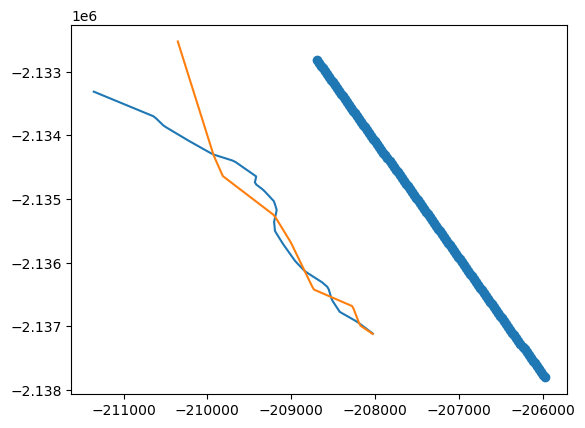

In [28]:
# Add a line plot connecting the points
# Look comments below before running this
points_x2 = [];
points_y2 = [];
# for points in points_x:
#   points_x2.append(points);
# for points in points_y:
#   points_y2.append(points);
for points in points_x:
 points_x2.append(points+1000);
for points in points_y:
 points_y2.append(points-1000);
plt.scatter(points_x2,points_y2)
plt.plot(line_points_list[0][0],line_points_list[0][1])
plt.plot(line_points_list[-1][0],line_points_list[-1][1])

337    2013-02-11
338    2013-03-18
339    2013-03-22
340    2013-03-27
341    2013-04-04
          ...    
521    2022-06-15
522    2022-07-11
523    2022-08-20
524    2022-09-04
525    2023-03-14
Name: Date, Length: 189, dtype: object

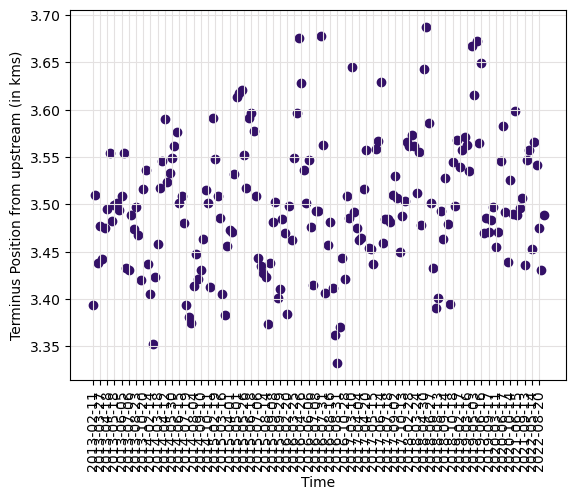

In [31]:
#Finding the distance from each point to the upstream terminus and then finding the average
dis = [];
for z in range(len(line_points_list)-n):
  d = [];
  for x in range(len(points_x)):
    xd = (line_points_list[z+n][0][x] - points_x2[x])**2 
    yd = (line_points_list[z+n][1][x] - points_y2[x])**2
    d.append(math.sqrt(xd+yd))
  dis.append(np.average(d)/1000)
ax = plt.scatter(gdf_date[n:],dis,color = '#331067')
interval = round(len(gdf_date)/12)
xz = 0;
dates = [];
interval = 3;
for date in gdf_date[n:]:
  if xz%interval == 0:
    dates.append(date)
  xz+=1
plt.xticks(dates,rotation=90);
#points
min_dist = dis.index(min(dis));
gdf_date[min_dist]
plt.grid('on', color = '#E4E1E1')
plt.xlabel('Time')
plt.ylabel('Terminus Position from upstream (in kms)')
# plt.savefig(root_path +  glacier_name +'/Terminus_Positions/'+'Terminus_plot_ '+ glacier_name + '.png',dpi=300,bbox_inches='tight', pad_inches=0)
gdf_date[n:]

In [20]:
del n

In [112]:
# Reading terminus ablation data
term_abl = pd.read_csv(root_path + 'Results/Output/Term_Ablation_' + glacier_name + '_' + region + '.csv')
from datetime import datetime
dt = datetime(2012, 1, 1)

# Convert datetime to datenum
datenumb = dt.toordinal() + 366
data_record = [];
f = 0;
for x in range(len(term_abl)):
  if term_abl.datenumb[f]>datenumb:
    data_record.append(term_abl.iloc[f])
  f+=1;
data_table = pd.DataFrame(data_record, columns=['datenumb','nmc','obs','term_ablation','discharge','term_abl_year'])
# Here to have the index of the table start from 1
ld = len(data_table)
transposed_index=np.array(list(range(ld)))
ssd = data_table.set_index(transposed_index)

ValueError: x and y must have same first dimension, but have shapes (72,) and (41,)

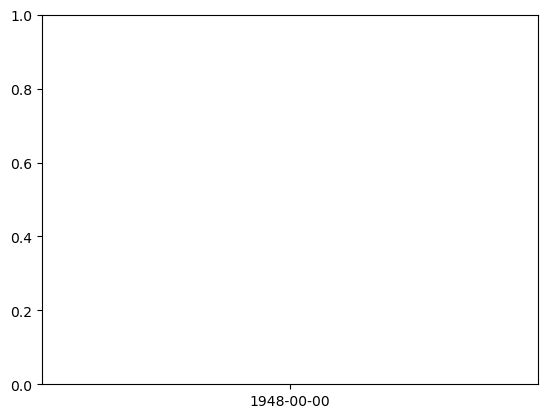

In [113]:
ta = ssd.term_abl_year
td = pd.to_datetime(ssd.datenumb-719529, unit='D')
fig,ax = plt.subplots()
# make a plot
ax.plot(gdf_date,dis,color="red", marker="o")
# set x-axis label
ax.set_xlabel("year", fontsize = 14)
# set y-axis label
ax.set_ylabel("Terminus Position (m)",color="red",fontsize=14)

ax2=ax.twinx()
ax2.plot(td,ta,color="blue",marker="o")
ax2.set_ylabel("Terminus Ablation (Gt/year)",color="blue",fontsize=14)
ax.set_xticks(dates)  # Use ax.set_xticks() instead of plt.xticks()
ax.set_xticklabels(dates, rotation=90)  # Set x-axis tick labels with rotation
plt.show()

ValueError: x and y must have same first dimension, but have shapes (22,) and (0,)

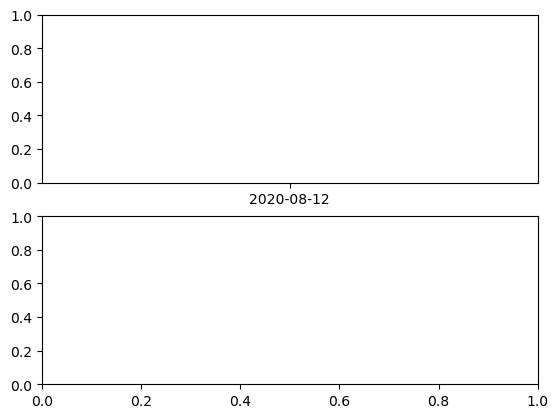

In [18]:
fig, ax = plt.subplots(2)

# make a plot
ax[0].plot(gdf_date[130:173], dis[130:173], color="red", marker="o",markersize=3)
# set x-axis label
#ax[0].set_xlabel("year", fontsize=14)
# set y-axis label
ax[0].set_ylabel("Terminus Position (m)", color="red", fontsize=10)
ax[0].set_xticks([])
#ax[0].set_xticks(dates)
#ax[0].set_xticklabels(dates,rotation=90)
#ax2 = ax.twinx()
ax[1].plot(td[59:109], ta[59:109], color="blue", marker="+",markersize=3)
ax[1].set_ylabel("Terminus Ablation (Gt/year)", color="blue", fontsize=10)
ax[0].set_title("Time series 2019 and beyond")
# Align the x-axis ticks between the two subplots
#ax[0].set_xticks(dates)
#ax2.set_xticks(dates)

# Set the tick labels for the twin x-axis
#ax.set_xticklabels(dates, rotation=90)
#ax2.set_xticklabels([])  # Hide the tick labels of ax2

plt.show()

## normalize before comparing stuff

ValueError: x and y must have same first dimension, but have shapes (128,) and (103,)

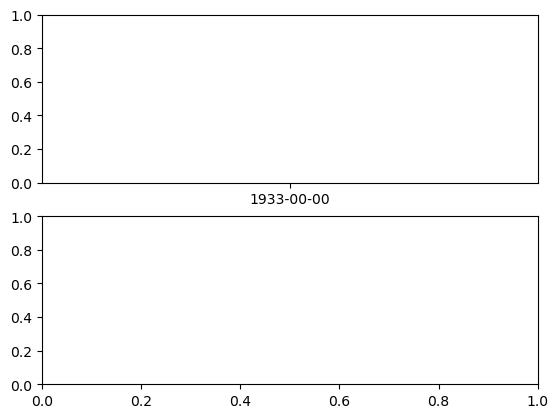

In [285]:
fig, ax = plt.subplots(2)

# make a plot
ax[0].plot(gdf_date, dis, color="red", marker="o",markersize=3)
# set x-axis label
#ax[0].set_xlabel("year", fontsize=14)
# set y-axis label
ax[0].set_ylabel("Terminus Position (m)", color="red", fontsize=10)
ax[0].set_xticks([])
#ax[0].set_xticks(dates)
#ax[0].set_xticklabels(dates,rotation=90)
#ax2 = ax.twinx()
ax[1].plot(td, ta, color="blue", marker="+",markersize=3)
ax[1].set_ylabel("Terminus Ablation (Gt/year)", color="blue", fontsize=10)

# Align the x-axis ticks between the two subplots
#ax[0].set_xticks(dates)
#ax2.set_xticks(dates)

# Set the tick labels for the twin x-axis
#ax.set_xticklabels(dates, rotation=90)
#ax2.set_xticklabels([])  # Hide the tick labels of ax2

plt.show()

## normalize before comparing stuff

In [18]:
## normalize before comparing stuff
dis_normailzed =[];
for value in dis:
  dis_normailzed.append((value - min(dis[129:173]))/(max(dis[129:173])-min(dis[129:173])))

print(min(dis[123:173]))
print(min(dis))
ta_normalized = [];
for value in ta:
  ta_normalized.append((value - min(ta[65:109]))/(max(ta[65:109])-min(ta[65:109])))

fig, ax = plt.subplots(2)

# make a plot
ax[0].plot(gdf_date, dis_normailzed, color="red", marker="o",markersize=3)
# set x-axis label
#ax[0].set_xlabel("year", fontsize=14)
# set y-axis label
ax[0].set_ylabel("Terminus Position (m)", color="red", fontsize=10)
ax[0].set_xticks([])
#ax[0].set_xticks(dates)
#ax[0].set_xticklabels(dates,rotation=90)
#ax2 = ax.twinx()
ax[1].plot(td, ta_normalized, color="blue", marker="+",markersize=3)
ax[1].set_ylabel("Terminus Ablation (Gt/year)", color="blue", fontsize=10)
ax[0].set_title("Normaized plots")

ValueError: min() arg is an empty sequence

In [19]:
import scipy
corr = scipy.signal.correlate(dis_normailzed[129:173], ta_normalized[65:109], mode='full', method='auto')
fig, (ax_dis, ax_ta, ax_corr) = plt.subplots(3, 1, sharex=True)
ax_dis.plot(dis_normailzed[129:173])
ax_dis.set_title('Terminus Distance')
ax_ta.plot(ta_normalized[65:109], 'ro')
ax_ta.set_title('Terminus Ablation')
ax_corr.stem(corr)
ax_corr.set_title('Cross-correlated')
fig.tight_layout()
plt.show()

NameError: name 'ta_normalized' is not defined

In [17]:
corr = scipy.signal.correlate(dis[133:173], ta[68:108], mode='full', method='auto')
fig, (ax_dis, ax_ta, ax_corr) = plt.subplots(3, 1, sharex=True)
ax_dis.plot(dis[133:173])
ax_dis.set_title('Terminus Distance')
ax_ta.plot(ta[68:108], 'ro')
ax_ta.set_title('Terminus Ablation')
ax_corr.stem(corr)
ax_corr.set_title('Cross-correlated')
fig.tight_layout()
plt.show()

NameError: name 'scipy' is not defined

In [36]:
matching_files

['/Users/amankc/Terminus_Ablation/Results/Output/Term_Ablation_latest_test2_CW.csv',
 '/Users/amankc/Terminus_Ablation/Results/Output/Term_Ablation_latest_Umiammakku_Sermiat_CW.csv',
 '/Users/amankc/Terminus_Ablation/Results/Output/Term_Ablation_latest_test1_CW.csv',
 '/Users/amankc/Terminus_Ablation/Results/Output/Term_Ablation_latest_test3_CW.csv']

In [64]:
csv_file[1]

,dates,term_abl_year
0,17-Jan-2013,0.968645
1,15-Feb-2013,2.446676
2,17-Mar-2013,0.924594
3,16-Apr-2013,0.291171
4,17-May-2013,2.320514
...,...,...
114,16-Sep-2022,0.967616
115,17-Oct-2022,1.001675
116,16-Nov-2022,1.222137
117,17-Dec-2022,1.074157


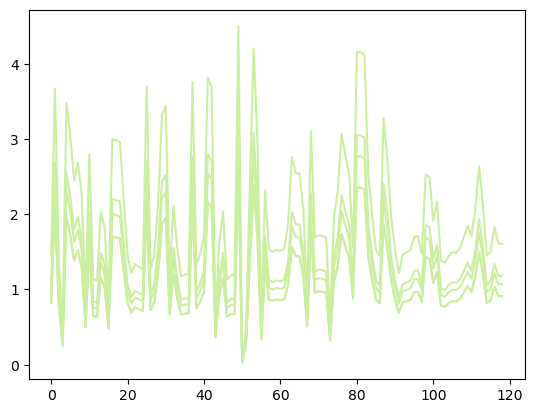

Text(0.5, 1.0, 'Ablation Time series for CW')

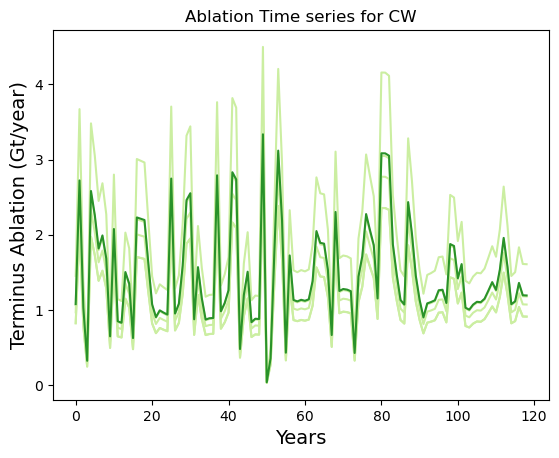

In [63]:
mean_term_abl = [];
region = 'CW';
for i in range(len(term_ablation2[0])):
    counter = 0;
    sum_term_abl = 0;
    for j in range(len(term_ablation2)):
        sum_term_abl = sum_term_abl + term_ablation2[j][i]
        counter += 1;
    mean_term_abl.append(sum_term_abl/counter);
fig,ax = plt.subplots()
ax = plt.plot(term_ablation2[0], color = color_code1)
#ax = plt.plot(date_axis, term_ablation2[0], color = color_code1) # Run this with the X axis 
for i in range(len(term_ablation2)):
    plt.plot(term_ablation2[i], color = color_code1)
plt.plot(mean_term_abl, color = color_code2)
plt.xlabel('Years',fontsize = 14)
plt.ylabel('Terminus Ablation (Gt/year)',fontsize = 14)
plt.title('Ablation Time series for ' + region)

In [264]:
len(line_points_list)

128